In [1]:
# -- mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [89]:
import sys
path_to_module = '/content/drive/MyDrive/CfA_hackathon/'
sys.path.append(path_to_module)

from utils import read_data
import numpy as np
import pickle as pkl
from tqdm import tqdm
import pandas as pd
import random
import matplotlib.pyplot as plt
from models import AD1
from tensorflow.keras.layers import Flatten, Reshape, Conv1D, MaxPooling1D, Conv1DTranspose, Dense, UpSampling1D
from keras.models import Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D,\
                         Dense, LeakyReLU, Reshape, Flatten, Add, InputLayer, BatchNormalization#from keras.layers import Conv2D, MaxPooling2
from keras import backend as K
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [3]:
import sys
path_to_module = '/content/drive/MyDrive/CfA_hackathon/'
sys.path.append(path_to_module)

from utils import read_data
import numpy as np
import pickle as pkl
from tqdm import tqdm
import pandas as pd
import random
import matplotlib.pyplot as plt
from models import AD1
from tensorflow.keras.layers import Flatten, Reshape, Conv1D, MaxPooling1D, Conv1DTranspose, Dense, UpSampling1D
from keras.models import Sequential


In [4]:
colors ={'u':"#00c2f2",
         'g':"#59b359",
         'r':"#e51f00",
         'i':"#502db3",
         'z':"#ffaa00",
         'y':"#f2b6de"
        }

classes = ['uLens-Single',
           'uLens-Binary']

In [150]:
# read the first 20 data points of the lightcurves in each of gri bands

data, label = read_data(path = path_to_module+'all_data_muLens_larger_than_3sigma.pkl',
                        n_points = 10)



2it [00:22, 11.15s/it]


In [151]:
data = data[:, :, [1,4]]

In [174]:
#split into train and test sets

random.seed(10)
data_size = len(label)
shuffler = np.random.permutation(len(label))
data = np.asarray(data)[shuffler]
label = np.asarray(label)[shuffler]
train_fract = 0.9
train_size = int(train_fract*data_size)
train_set = data[:train_size]
train_label = np.asarray(label)[:train_size]

test_set = data[train_size:]
test_label = np.asarray(label)[train_size:]

In [175]:
# Read an example light curve

class_ind = 1
ind = 8

f = train_set[train_label == class_ind][ind]
# print(f[:,0])


for b, band in enumerate(['r', 'i']):

    plt.errorbar(f[:,3*b],
                 f[:,3*b+1],
                 yerr = f[:,3*b+2],
                 fmt = 'o-',
                 color = colors[band],
                 label = band)

plt.legend()
plt.title(classes[class_ind])
plt.xlabel('Time (mjd)')
plt.ylabel('Flux')

IndexError: index 2 is out of bounds for axis 1 with size 2

In [176]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
train_set = scaler.fit_transform(train_set.reshape(train_set.shape[0], -1)).reshape(train_set.shape[0], data.shape[1], data.shape[2])
test_set = scaler.fit_transform(test_set.reshape(test_set.shape[0], -1)).reshape(test_set.shape[0], data.shape[1], data.shape[2])

In [177]:
np.sum(test_label)

158

In [178]:
input_img = keras.Input(shape=(train_set.shape[1], train_set.shape[2]))
# input2 = keras.Input(shape=(3, ))
# input3 = keras.Input(shape=(3, ))
# input4 = keras.Input(shape=(3, ))



x1 = keras.layers.Conv1D(16, 3, activation= 'relu', strides=1, padding="same")(input_img)
x4 = keras.layers.Conv1D(32, 2, activation= 'relu', strides=1, padding="same")(x1)
x5 = keras.layers.MaxPooling1D(3)(x4)
x6 = Flatten()(x5)
x7 = Dense(256, activation= 'relu')(x6)
x10 = Dense(1, activation='sigmoid')(x7)

model = keras.Model([input_img], x10)

In [179]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 10, 2)]           0         
                                                                 
 conv1d_39 (Conv1D)          (None, 10, 16)            112       
                                                                 
 conv1d_40 (Conv1D)          (None, 10, 32)            1056      
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 3, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 96)                0         
                                                                 
 dense_32 (Dense)            (None, 256)               24832     
                                                          

In [180]:
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                      loss=keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [181]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.000001,
                                          patience=10)
history = model.fit(train_set,
                    train_label.reshape(-1, 1),
                    epochs=100,
                    batch_size=8,
                    validation_split=0.2,
                    callbacks = [es])

Epoch 1/100
660/660 [==============================] - 4s 4ms/step - loss: 0.5385 - accuracy: 0.7923 - val_loss: 0.5256 - val_accuracy: 0.7924
Epoch 2/100
660/660 [==============================] - 2s 4ms/step - loss: 0.5037 - accuracy: 0.8056 - val_loss: 0.5225 - val_accuracy: 0.7924
Epoch 3/100
660/660 [==============================] - 2s 4ms/step - loss: 0.4992 - accuracy: 0.8056 - val_loss: 0.5153 - val_accuracy: 0.7924
Epoch 4/100
660/660 [==============================] - 3s 4ms/step - loss: 0.4946 - accuracy: 0.8056 - val_loss: 0.5137 - val_accuracy: 0.7924
Epoch 5/100
660/660 [==============================] - 4s 7ms/step - loss: 0.4908 - accuracy: 0.8054 - val_loss: 0.5099 - val_accuracy: 0.7924
Epoch 6/100
420/660 [==================>...........] - ETA: 0s - loss: 0.4885 - accuracy: 0.8060

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

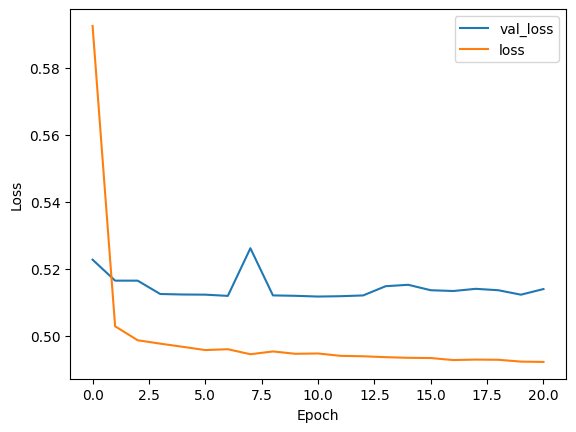

In [161]:
plt.plot(history.history['val_loss'], '-')

plt.plot(history.history['loss'], '-')
plt.legend(['val_loss', 'loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

In [162]:
loss_and_metrics = model.evaluate(test_set, test_label.reshape(-1, 1))
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

23/23 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.8215
[0.46535447239875793, 0.8215258717536926]
Loss =  0.46535447239875793
Accuracy =  0.8215258717536926


In [163]:
predicted = model.predict(train_set)

207/207 [==============================] - 1s 2ms/step


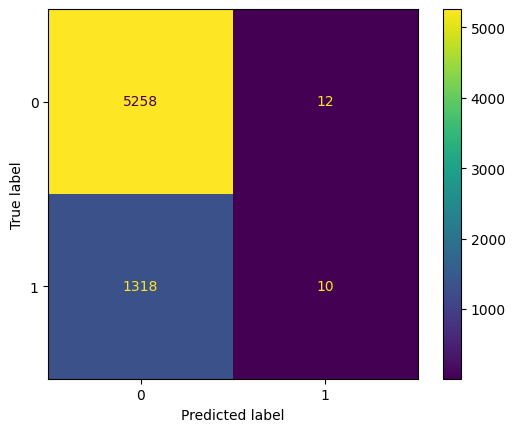

In [164]:
predicted = tf.squeeze(predicted)
predicted = np.array([1 if x >= 0.3 else 0 for x in predicted])
actual = np.array(train_label)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [129]:
actual

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [130]:
predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,